In [109]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

In [148]:
# Load in CSV file for ML model to train and test with
data = pd.read_csv('../../Cleaned/14-18_ML_test.csv')
# Drop null or NA values from df
data = data.dropna()

In [149]:
# Drop the index and Time Group Columns as we do not need them for the model
data = data.drop(columns=['Unnamed: 0','Time Group','Other Weather','Gender Neutral'])
# Disply all column names to ensure accuracy. These will be 'X' values in Model
list(data.columns)

['Age',
 'Previous Accident',
 'Previous DWI',
 'Previous Speeding',
 'INJ_SEV',
 'Helmet Use',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'Sunday',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Male',
 'Female',
 'No Drugs',
 'Drug Use Reported',
 'No Drinking',
 'Drinking Reported',
 'Clear Weather',
 'Rainy Weather',
 'Foggy Weather',
 'Severly Windy Weather',
 'Blowing Sand Weather',
 'Cloudy Weather']

In [150]:
# Feeding data into our model
X = data.drop("INJ_SEV", axis=1)
y = data["INJ_SEV"]
# Print shape of model data
print(X.shape, y.shape)

(3839, 36) (3839,)


In [151]:
# Import TTS for training model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [152]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

#giving weight to each outcome to train model
weights = {0:2,1:0.8,2:0.2}

# Creating Classifier with estimators and weights
grid = RandomForestClassifier(n_estimators=1000, class_weight=weights)

# Training the model
grid.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 0.8, 2: 0.2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [153]:
# param_grid = {"n_estimators" : [50, 100, 200,250],
#              "max_depth" : [None, 6, 8, 10],
#              "max_leaf_nodes": [None, 5, 10, 20]}
# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(grid, param_grid=param_grid, cv=5, verbose=2)
# # grid.fit(X_train,y_train)

In [154]:
# Print Training and Test data
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.9947898575894408
Testing Data Score: 0.83125


In [155]:
# Prit out dredictions vs reality
predictions = grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}") 

First 10 Predictions:   [2 0 2 2 2 0 0 2 0 2]
First 10 Actual labels: [2, 0, 2, 2, 2, 0, 1, 2, 0, 2]


In [156]:
# Visualize probability of each outcome
probs = grid.predict_proba(X_test)
pred_df = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test, 
    "P(No Injury)": [p[0] for p in probs], 
    "P(Injury)": [p[1] for p in probs],
    "P(Fatility)": [p[2] for p in probs]
    }).reset_index(drop=True)

pred_df.head(10)

,Prediction,Actual,P(No Injury),P(Injury),P(Fatility)
0,2,2,0.162,0.084000,0.754000
1,0,0,0.443,0.142000,0.415000
2,2,2,0.020,0.062000,0.918000
3,2,2,0.029,0.288571,0.682429
4,2,2,0.001,0.014000,0.985000
5,0,0,0.981,0.009000,0.010000
6,0,1,0.691,0.303000,0.006000
7,2,2,0.000,0.058000,0.942000
8,0,0,0.939,0.009000,0.052000
9,2,2,0.025,0.220000,0.755000


In [157]:
# Imported so that confusion matrix can be plotted. Import code from SKLearn is broken
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[235  29  11]
 [ 49  41  42]
 [ 16  15 522]]


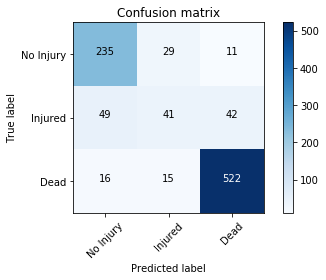

In [158]:
# Create confusion matrix and matricies for [0] - No Injury; [1] - Injured
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions)

plot_confusion_matrix(cm, cmap=plt.cm.Blues, classes=['No Injury','Injured','Dead'])

In [159]:
# Plot out feature importance descending
pd.DataFrame({'Feature':X_train.columns, 'Importance':grid.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,Helmet Use,0.351516
0,Age,0.221263
3,Previous Speeding,0.047693
1,Previous Accident,0.031479
23,Saturday,0.020320
17,Sunday,0.016727
10,June,0.016036
30,Clear Weather,0.015473
22,Friday,0.014715
35,Cloudy Weather,0.014061


In [160]:
import pickle

with open('RF_model.pkl','wb') as f:
    pickle.dump(grid, f)

In [161]:
with open('RF_model.pkl', 'rb') as f:
    model = pickle.load(f)


In [162]:
print(f"Test set score: {model.score(X_test, y_test)}")

Test set score: 0.83125


In [163]:
model

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 0.8, 2: 0.2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)